In [58]:
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
from math import log2
from scipy.stats import chisquare, kstest
from AES_MessageEncryption import AES_Encrypt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import tensorflow as tf

## Task 1: Playing with Pseudo-Randomness

### Part A: Implement and Benchmark an LCG

In [34]:
def Linear_Congruential_Generator(seed, multiplier, increment, modulus, N_steps):
    
    """
    Generate a sequence using a Linear Congruential Generator (LCG).

    Parameters:
        seed (int): Initial value (X_0) of the sequence.
        multiplier (int): The multiplier 'a' in the LCG recurrence.
        increment (int): The increment 'c' in the LCG recurrence.
        modulus (int): The modulus 'm' to ensure wrap-around.
        N_steps (int): Number of LCG iterations to compute.

    Returns:
        List[int]: The list/array of LCG outputs, including the initial seed.
    """
    
    sequence = [seed]  # Initialize with the seed value

    for i in range(N_steps):
        # Compute the next value in the sequence using the LCG formula and append it to the sequence array
        X_n = (multiplier * sequence[i] + increment) % modulus
        sequence.append(X_n)

    return sequence

#### Demonstrating a Full-Period LCG
<small> According to the Hull-Dobell Theorem, a linear congruential generator (LCG) will have a full period (i.e., cycle through all possible values modulo `m` before repeating) if:
1. `c` and `m` are coprime,
2. `a - 1` is divisible by all prime factors of `m`,
3. If `m` is divisible by 4, then `a - 1` must also be divisible by 4.

We choose:
- `a = 5`
- `c = 1`
- `m = 16`
- `seed = 2`

This setup satisfies the Hull-Dobell Theorem, and we expect the generator to cycle through all 16 values before repeating.

In [35]:
"""
Full-period LCG satisfying the Hull-Dobell Theorem
# Parameters:
# seed = 2 (any integer < m)
# a = 5, c = 1, m = 16 
This will generate a full cycle before repeating
"""

output = Linear_Congruential_Generator(seed=2, multiplier=5, increment=1, modulus=16, N_steps=17) # N_steps = 17 shows periodicity
print("LCG output:", output)

LCG output: [2, 11, 8, 9, 14, 7, 4, 5, 10, 3, 0, 1, 6, 15, 12, 13, 2, 11]


#### Job: Run the LCG for at least 10⁶ steps
<small> To analyze long-term behavior, we generate a sequence using the Linear Congruential Generator for 10^6 steps. We use the previously determined parameters that satisfy the Hull-Dobell Theorem (a = 5, c = 1, m = 16) to ensure full-period behavior over the modulus.

In [36]:
# Run LCG for a long sequence of 10^6 steps using full-period parameters
seed = 2
a = 5
c = 1
m = 16
N = 10**6

lcg_long_seq = Linear_Congruential_Generator(seed, a, c, m, N)

#### Job: Visualize the Distribution of LCG Outputs

<small>We generate a histogram of the output values from the LCG after 10^6 steps. This helps assess whether the values are uniformly distributed over the modulus range, which is a key property for evaluating the quality of PRNGs.

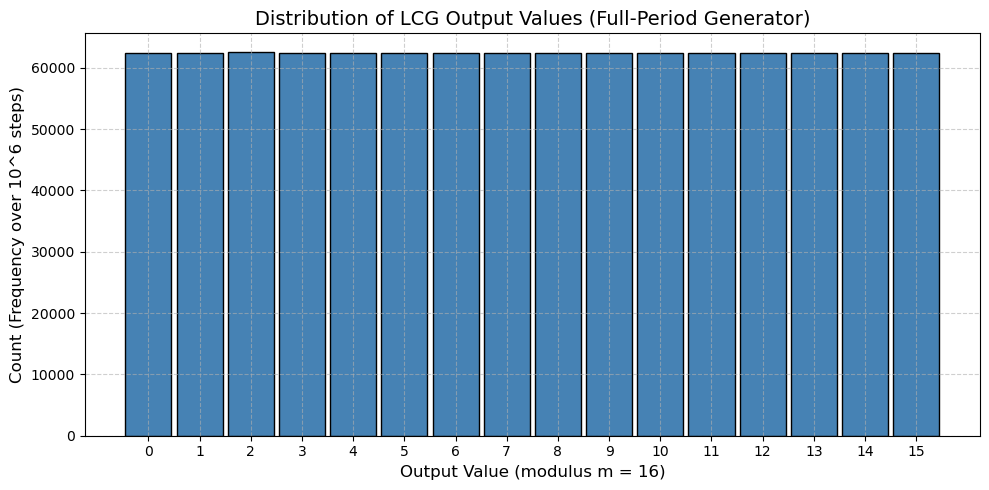

In [37]:
# Parameters (satisfying Hull-Dobell for full period)
seed = 2
a = 5
c = 1
m = 16
N = 10**6

# Generate the sequence
sequence = Linear_Congruential_Generator(seed, a, c, m, N)

# Plot histogram of output values from the LCG
plt.figure(figsize=(10, 5))

plt.hist(sequence, bins=m, range=(0, m), color='steelblue', edgecolor='black', align='left', rwidth=0.9)

plt.title("Distribution of LCG Output Values (Full-Period Generator)", fontsize=14)
plt.xlabel(f"Output Value (modulus m = {m})", fontsize=12)
plt.ylabel("Count (Frequency over 10^6 steps)", fontsize=12)

plt.xticks(range(m))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

#### Histogram Interpretation

<small>This histogram shows the output distribution of the LCG over 10^6 steps with parameters satisfying the Hull-Dobell Theorem (HDT), ensuring a full-period generator.

- The output spans uniformly across states `0` to `m-1`, indicating good randomness and full state space coverage.
- A roughly uniform distribution confirms that outputs appear with similar frequency, desirable for a PRNG.

#### Entropy Analysis

<small> We know entropy metrics quantify the randomness and unpredictability of sequences generated by PRNGs like Linear Congruential Generators (LCGs).

- **Shannon Entropy** measures the average uncertainty in the output distribution, indicating how uniformly the values are spread.
- **Min Entropy** captures the worst-case predictability, revealing if some values occur more frequently and reduce randomness.

By analyzing how these entropy values evolve over many steps, we assess the quality and strength of the LCG with given parameters. This helps identify weaknesses like short periods, patterns, or biases that compromise randomness, this is crucial for applications requiring secure or high-quality randomness.

We first define a function that calculated both the Shannon and Min Entropy of a Probability Distribution and then we compute the entropy at regular intervals over a large sample size to benchmark the LCG's performance effectively.

In [38]:
def compute_entropy(X, method='shannon'):
    
    """
    Compute entropy (Shannon or Min) of a distribution.
    
    Parameters:
    - X: array-like or dict
        Can be:
            - NumPy array of outcomes
            - Dict of {outcome: probability}
                a (key, value) pair represents an outcome x and its probability P(X = x)
    - method: 'shannon' or 'min'
    
    Returns:
    - Entropy value
    """

    if isinstance(X, dict):
        # Already a probability distribution
        values = np.array(list(X.values()))
    
    else:
        # Assume array-like sample
        X = np.array(X)
        _, counts = np.unique(X, return_counts=True) 
        values = counts / counts.sum()  # Normalize to probabilities

    # Remove zero probabilities to avoid log(0)
    values = values[values > 0]

    if method == 'shannon':
        return -np.sum(values * np.log2(values))
    
    elif method == 'min':
        return -np.log2(np.max(values))
    
    else:
        raise ValueError("Method must be 'shannon' or 'min'")

#### Entropy Evolution of LCG Output

<small>We fix a short seed (≤ 2^10) and generate a long LCG sequence (10^6 steps).

At regular intervals (every 1000 steps), we compute two entropy metrics from the empirical distribution of outputs so far:

- **Shannon Entropy:** Average uncertainty in the distribution, indicating overall randomness.
- **Min Entropy:** Worst-case predictability, reflecting if certain values dominate.

Plotting these entropies against iteration count reveals how randomness quality evolves as the generator produces more values.

A full-period LCG with good parameters should approach high entropy values quickly and maintain them, indicating uniform output distribution and strong randomness.

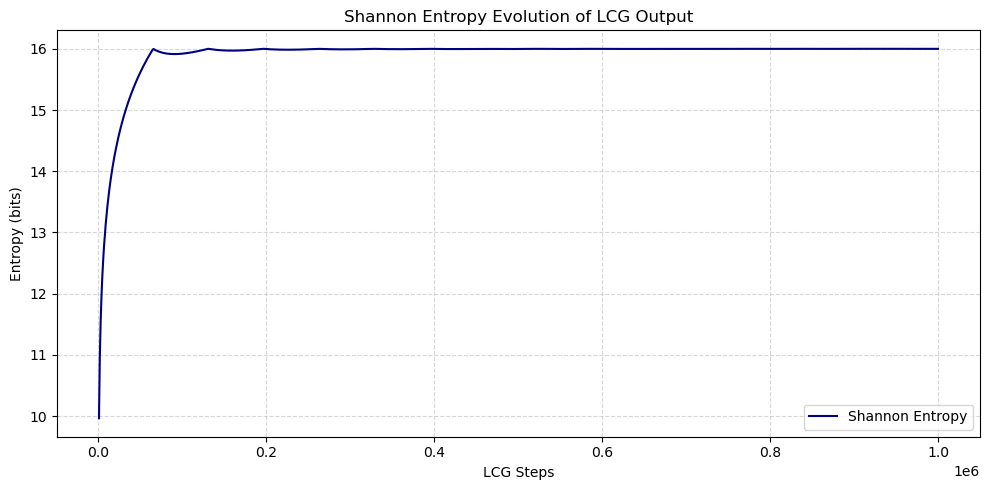

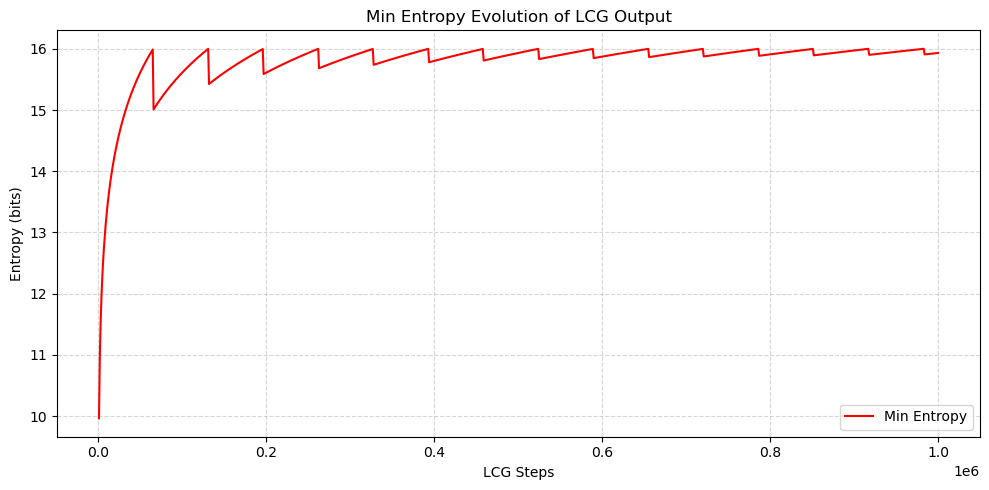

In [39]:
# Parameters: Full-period LCG with seed ≤ 2^10
seed = 7
a, c, m = 65, 3, 2**16  # multiplier, increment, modulus
N = 10**6               # total steps
interval = 1000         # steps between entropy calculations

"""
We use these specific parameters to ensure a meaningful entropy analysis:

-> seed = 7 satisfies the task constraint (≤ 2^10 unique values).
-> m = 2^16 allows a large output space (65536 values), which is essential for
  observing evolving entropy over time. Small moduli (like m = 16) are too limited.
-> a = 65 and c = 3 satisfy the Hull-Dobell Theorem:
    -> c is coprime with m (odd vs even)
    -> a - 1 = 64 is divisible by all prime factors of m (only 2)
    -> a - 1 is also divisible by 4, since m is a power of 2
    
These choices guarantee a full-period LCG, producing high-quality pseudo-random output
for entropy tracking across 10^6 samples.
"""

# Generate LCG sequence
lcg_seq = Linear_Congruential_Generator(seed, a, c, m, N)

# Prepare lists to store entropy values and checkpoints
shannon_entropy_vals = []
min_entropy_vals = []
checkpoints = []

# Compute entropy at regular intervals over the growing sample
for i in range(interval, len(lcg_seq), interval):
    sample = lcg_seq[:i]
    H_shannon = compute_entropy(sample, method='shannon')
    H_min = compute_entropy(sample, method='min')

    shannon_entropy_vals.append(H_shannon)
    min_entropy_vals.append(H_min)
    checkpoints.append(i)

# Plot Shannon Entropy evolution
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, shannon_entropy_vals, label="Shannon Entropy", color='navy')
plt.xlabel("LCG Steps")
plt.ylabel("Entropy (bits)")
plt.title("Shannon Entropy Evolution of LCG Output")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Min Entropy evolution
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, min_entropy_vals, label="Min Entropy", color='red')
plt.xlabel("LCG Steps")
plt.ylabel("Entropy (bits)")
plt.title("Min Entropy Evolution of LCG Output")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

<small>
This choice of parameters has a relatively small modulus (2^16) which limits the output range to 16-bit values. The multiplier and increment are chosen as small integers. This configuration allows diving into the entropy growth and randomness quality over one million iterations (or over time).

#### Shannon Entropy Evolution of LCG Output:
<small> Observation:
- The Shannon entropy starts low and grows over time.
- It saturates near 15-16 bits, consistent with the 16-bit modulus.
- Early stages show low entropy reflecting initial predictability.

Explanation:
Because the output values are constrained to 16 bits (65536 possible values), the maximum Shannon entropy attainable is about 16 bits. The curve shows how the LCG output distribution evolves from highly predictable initial states to a more uniform distribution, increasing entropy as the sequence progresses.


#### Min Entropy Evolution of LCG Output:
<small>Observation:
- The min entropy shows more fluctuations than Shannon entropy.
- It roughly approaches but may not fully reach the maximum possible value (~16 bits).
- Drops correspond to transient clustering of outputs.

Explanation:
Min entropy is sensitive to the highest probability of any single output value. Temporary clustering or cycles cause occasional dips in min entropy. Over long iterations, the output distribution evens out, increasing min entropy toward the upper bound imposed by the modulus and hence showing that the predictability decreases.

### Part B: Implement and Benchmark AES-Based PRNGs

#### AES-ECB PRNG & Statistical Analysis Toolkit  
<small>This project implements a pseudo-random number generator based on AES-128 in ECB mode with feedback, along with tools to analyze the statistical quality of the output.</small>

---

#### 1. Purpose  
<small>
This script demonstrates how AES encryption can be used to generate pseudo-random bytes via ECB mode with feedback. Although not cryptographically secure, this generator serves educational and statistical analysis purposes. It also provides tools to evaluate randomness using entropy plots, autocorrelation analysis, and goodness-of-fit statistical tests.
</small>

---

#### 2. Dependencies  
<small>

| Library                       | Purpose                                  |
|------------------------------|------------------------------------------|
| `numpy`                      | Efficient numerical operations            |
| `scipy.stats`                | Statistical testing (χ² and KS tests)     |
| `matplotlib.pyplot`          | Visualization of entropy and autocorrelation |
| `AES_MessageEncryption`      | Provides `AES_Encrypt()` implementation   |

</small>

---

#### 3. Structure Overview  
<small>

| Section | Description |
|--------|-------------|
| **1. Utilities** | Functions for seed padding, matrix conversion, and byte coercion |
| **2. AES PRNG** | Implements AES-128 ECB-mode PRNG with feedback |
| **3. Analysis Routines** | Functions to visualize entropy, autocorrelation, and perform χ² / KS tests |
| **4. Main Loop** | Runs tests for various seed and output lengths |

</small>

---

#### 4. Utility Functions  

- `pad_seed(seed: bytes, target_len: int = 16) -> bytes`  
  <small>Repeats or truncates a byte string so it is exactly 16 bytes long.</small>

- `bytes_to_matrix(b: bytes)`  
  <small>Converts 16 bytes into a 4×4 AES state matrix in column-major order with each entry as a hex string.</small>

- `to_uint8_array(seq) -> np.ndarray`  
  <small>Converts various byte-like inputs into a flat NumPy `uint8` array. Handles strings, lists, and buffers robustly.</small>

---

#### 5. AES-ECB PRNG  

- `AES_PRNG(seed: bytes, num_bytes: int) -> bytes`  
  <small>
  Generates `num_bytes` of output using AES-128 in ECB mode with feedback.  
  - Valid seed lengths: 1, 2, 4, 8, or 16 bytes  
  - The seed is used to derive both the AES key and the initial input block  
  - Each new block is encrypted and fed back as input  
  - Output is built by concatenating encrypted blocks  
  </small>

---

#### 6. Analysis Functions  

- `plot_entropy(sequence, window_size=1000)`  
  <small>
  Plots the Shannon entropy in bits per byte over a sliding window of the generated sequence. High entropy (close to 8 bits) indicates better uniformity.
  </small>

- `plot_autocorrelation(sequence, max_lag=100)`  
  <small>
  Computes and plots autocorrelation up to a given lag. A good PRNG will exhibit low autocorrelation (ideally near 0) at all non-zero lags.
  </small>

- `run_statistical_tests(sequence, bins=256, alpha=0.05)`  
  <small>
  Applies:
  - **Chi-Square (χ²)** test to compare byte frequencies to expected uniform distribution.
  - **Kolmogorov–Smirnov (KS)** test for uniformity across [0, 256).
  Reports test statistics and p-values.
  </small>

---

#### 7. Experiment Loop  

<small>
The main loop performs experiments for:
- **Seed lengths:** 1, 2, 8 bytes → corresponds to 8, 16, 64 bits
- **Sequence lengths:** 10⁵, 10⁶, 10⁷ bytes

For each seed and sequence:
1. Generate random seed
2. Generate pseudo-random byte stream
3. Plot entropy over sliding window
4. Plot autocorrelation up to lag 100
5. Run χ² and KS statistical tests
</small>

---



​=== Seed = 8 bits ===

Generating 100,000 bytes… done.
→ Entropy (window=1000)


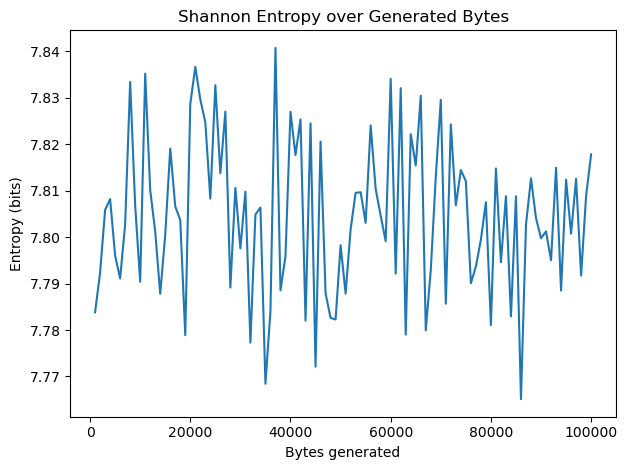

→ Autocorrelation (lag 0–100)


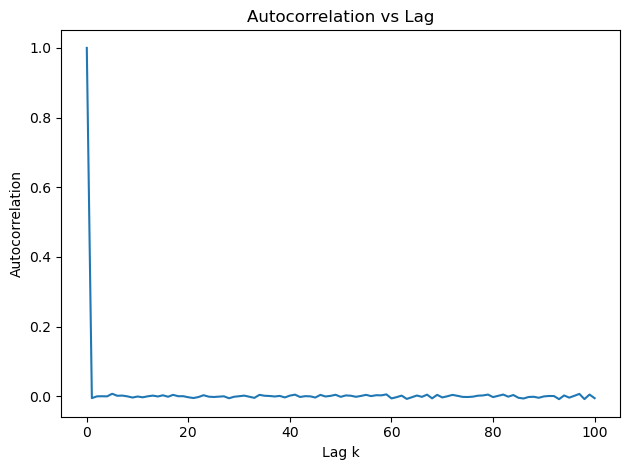

→ Statistical tests
χ² → stat=268.14, p=0.274 
KS → stat=0.0053, p=0.008


Generating 1,000,000 bytes… done.
→ Entropy (window=10000)


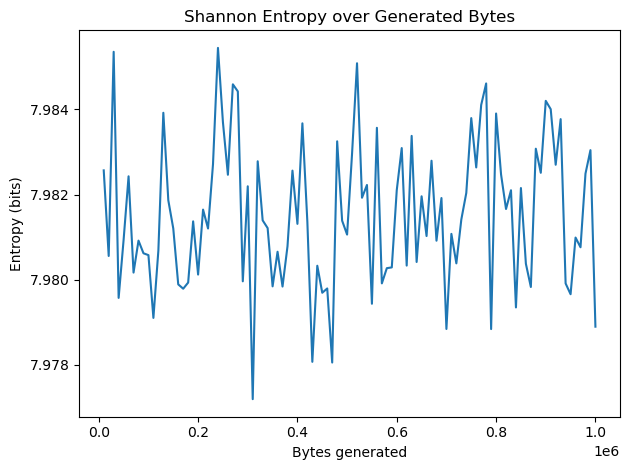

→ Autocorrelation (lag 0–100)


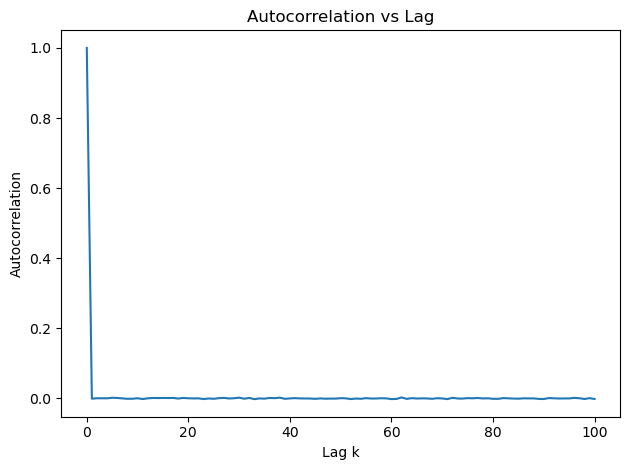

→ Statistical tests
χ² → stat=239.38, p=0.751 
KS → stat=0.0043, p=0.000


Generating 10,000,000 bytes…

KeyboardInterrupt: 

In [57]:
# ── 1) Utilities ──────────────────────────────────────────────────────────────

def pad_seed(seed: bytes, target_len: int = 16) -> bytes:
    """Repeat/truncate seed so it’s exactly `target_len` bytes."""
    if len(seed) > target_len:
        return seed[:target_len]
    reps = (target_len // len(seed)) + 1
    return (seed * reps)[:target_len]

def bytes_to_matrix(b: bytes):
    """Convert 16 bytes → 4×4 AES state matrix (column‐major)."""
    assert len(b) == 16
    return [[f"0x{b[r + 4*c]:02x}" for c in range(4)] for r in range(4)]

def to_uint8_array(seq) -> np.ndarray:
    """
    Coerce seq (bytes, bytearray, or array‐like) into a 1-D np.uint8 array.
    """
    if isinstance(seq, (bytes, bytearray)):
        return np.frombuffer(seq, dtype=np.uint8)
    arr = np.asarray(seq)
    if arr.dtype.kind in ('U','S'):
        # array of Python bytes/str → join → buffer
        raw = b''.join(arr.tolist())
        return np.frombuffer(raw, dtype=np.uint8)
    return arr.astype(np.uint8)

# ── 2) AES‐ECB PRNG ────────────────────────────────────────────────────────────

def AES_PRNG(seed: bytes, num_bytes: int) -> bytes:
    """
    AES‐ECB with feedback:
      - seed: 1,2,4,8, or 16 bytes
      - repeats seed → 16‐byte key + 16‐byte initial block
      - encrypt block, append bytes, set block=output, repeat
    """
    assert len(seed) in (1,2,4,8,16)
    key = pad_seed(seed, 16)
    state = pad_seed(seed, 16)
    key_mat = bytes_to_matrix(key)
    out = bytearray()
    while len(out) < num_bytes:
        blk_mat = bytes_to_matrix(state)
        enc_mat = AES_Encrypt(blk_mat, key_mat)
        # flatten column-wise
        enc = bytes(int(enc_mat[r][c],16) for c in range(4) for r in range(4))
        out.extend(enc)
        state = enc
    return bytes(out[:num_bytes])

# ── 3) Analysis Routines ─────────────────────────────────────────────────────

def plot_entropy(sequence, window_size=1000):
    """Plot Shannon entropy (bits) in successive windows."""
    data = to_uint8_array(sequence)
    num_chunks = len(data) // window_size
    Hs, xs = [], []
    for i in range(num_chunks):
        chunk = data[i*window_size:(i+1)*window_size]
        counts = np.bincount(chunk, minlength=256)
        p = counts[counts>0]/window_size
        Hs.append(-np.sum(p * np.log2(p)))
        xs.append((i+1)*window_size)
    plt.figure()
    plt.plot(xs, Hs)
    plt.title("Shannon Entropy over Generated Bytes")
    plt.xlabel("Bytes generated")
    plt.ylabel("Entropy (bits)")
    plt.tight_layout()
    plt.show()

def plot_autocorrelation(sequence, max_lag=100):
    """Plot autocorrelation vs lag."""
    data = to_uint8_array(sequence).astype(np.float64)
    μ, σ2 = data.mean(), data.var()
    ac = [1.0]
    for lag in range(1, max_lag+1):
        cov = ((data[:-lag]-μ)*(data[lag:]-μ)).mean()
        ac.append(cov/σ2)
    plt.figure()
    plt.plot(range(max_lag+1), ac)
    plt.title("Autocorrelation vs Lag")
    plt.xlabel("Lag k")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

def run_statistical_tests(sequence, bins=256, alpha=0.05):
    """Run χ² and Kolmogorov–Smirnov tests against uniform[0,256)."""
    data = to_uint8_array(sequence)
    counts = np.bincount(data, minlength=bins)
    χ2_stat, χ2_p  = chisquare(counts)
    ks_stat, ks_p = kstest(data, 'uniform', args=(0,256))
    print(f"χ² → stat={χ2_stat:.2f}, p={χ2_p:.3f}", 
          f"\nKS → stat={ks_stat:.4f}, p={ks_p:.3f}\n")

# ── 4) Main Loop ──────────────────────────────────────────────────────────────

seed_lengths     = [1, 2, 8]             # bytes → 8,16,64 bits
sequence_lengths = [10**5, 10**6, 10**7]  # bytes to generate

for s in seed_lengths:
    seed = np.random.bytes(s)
    print(f"\n​=== Seed = {8*s} bits ===")
    for N in sequence_lengths:
        print(f"\nGenerating {N:,} bytes…", end="")
        seq = AES_PRNG(seed, N)
        print(" done.")

        w = max(1, N//100)
        print(f"→ Entropy (window={w})")
        plot_entropy(seq, window_size=w)

        print("→ Autocorrelation (lag 0–100)")
        plot_autocorrelation(seq, max_lag=100)

        print("→ Statistical tests")
        run_statistical_tests(seq, bins=256)


### (BONUS) Part C: Breaking the Illusion of Randomness

#### Bonus Task:
<small> Train a light-weight model (small-neural net or decision tree) to predict the next number in your random number sequences generated from LCG and AES. Now try implementing at least one other more robust PRNGs from the list below:
- XOR-Shift Generator
- Permuted Congruential Generator (PCG) 
- SplitMix64 

#### PRNG Predictability Analysis

<small> This code analyzes the predictability of various Pseudorandom Number Generators (PRNGs) using machine learning techniques. It generates sequences from different PRNGs and attempts to predict the next number in each sequence using both neural networks and decision trees.

The code implements several PRNG algorithms including **XORShift**, **PCG (Permuted Congruential Generator)**, **SplitMix64**, **Linear Congruential Generator (LCG)**, and an **AES-based PRNG**. For each algorithm, it generates training and testing data, trains prediction models, evaluates their performance, and visualizes the results.

The neural network model uses a **GRU-based architecture** to capture sequential patterns in the data, while the decision tree attempts to find rules that can predict the next value in a sequence. Both models are evaluated using **Mean Squared Error (MSE)** and **R² scores**, with higher R² values indicating greater predictability.

The visualizations include **scatter plots** comparing actual vs. predicted values and a **bar chart** comparing R² scores across all PRNGs. The scatter plots help identify how well each model can predict values (points along the diagonal indicate accurate predictions), while the bar chart provides a direct comparison of predictability across different algorithms.

This analysis demonstrates that **cryptographically secure PRNGs like AES** are significantly less predictable than simpler algorithms like LCG, which has important implications for applications requiring strong randomness. The horizontal red line at **R² = 0** in the final bar chart represents the baseline of no predictability, helping to contextualize the performance of each PRNG.



Experiment: Linear Congruential Generator
Data shape: X=(1000, 20), y=(1000,)

Training Neural Network...
Epoch [20/100], Loss: 0.144233
Epoch [40/100], Loss: 0.100571
Epoch [60/100], Loss: 0.094564
Epoch [80/100], Loss: 0.093389
Epoch [100/100], Loss: 0.092929
Neural Network - MSE: 0.099640, R²: 0.002881

Training Decision Tree...
Decision Tree - MSE: 0.150138, R²: -0.502469


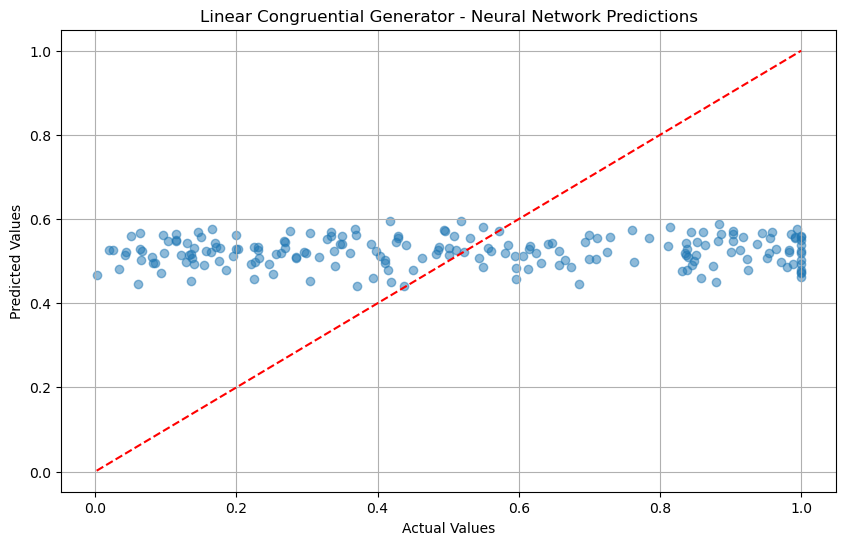

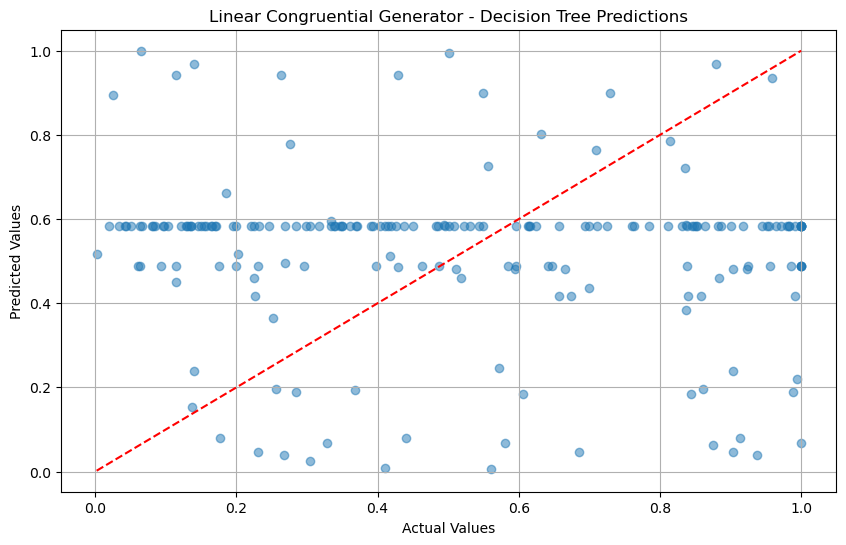


Experiment: XOR-Shift Generator
Data shape: X=(1000, 20), y=(1000,)

Training Neural Network...
Epoch [20/100], Loss: 0.183089
Epoch [40/100], Loss: 0.099867
Epoch [60/100], Loss: 0.095642
Epoch [80/100], Loss: 0.094892
Epoch [100/100], Loss: 0.094625
Neural Network - MSE: 0.087801, R²: -0.013544

Training Decision Tree...
Decision Tree - MSE: 0.045875, R²: 0.470436


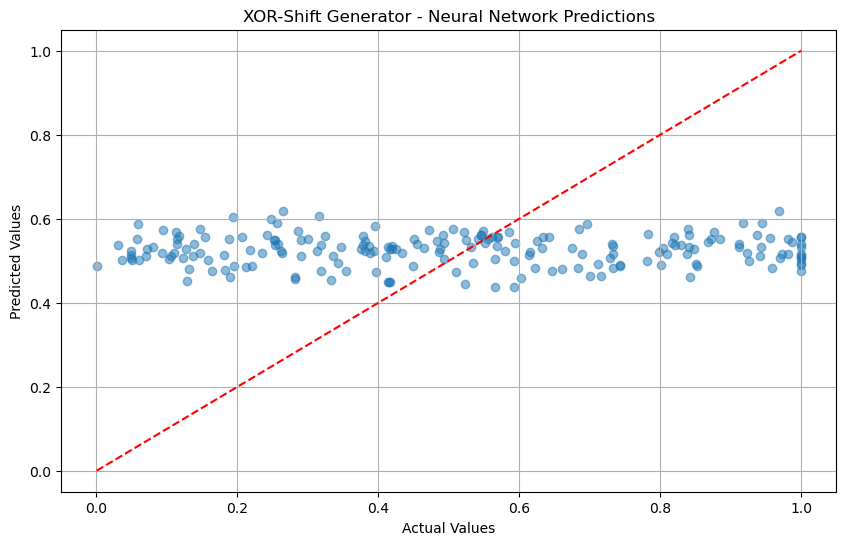

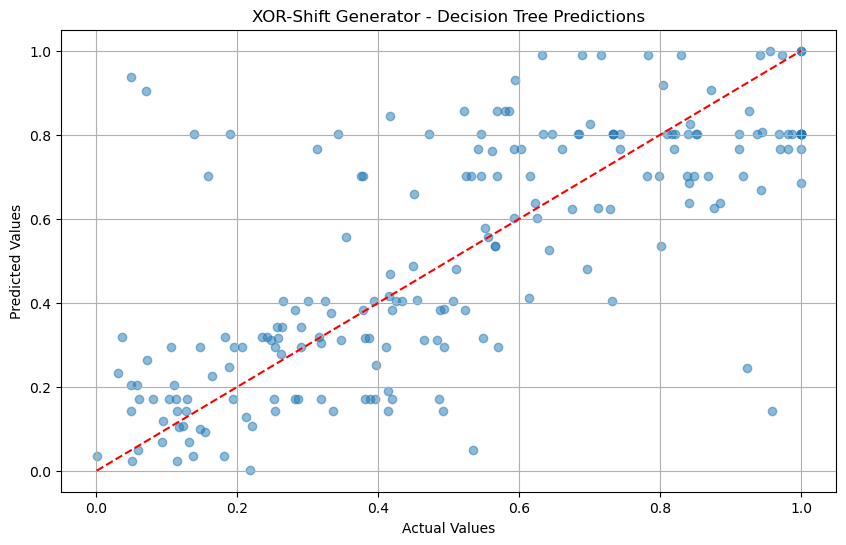


Experiment: Permuted Congruential Generator
Data shape: X=(1000, 20), y=(1000,)

Training Neural Network...
Epoch [20/100], Loss: 0.164162
Epoch [40/100], Loss: 0.088607
Epoch [60/100], Loss: 0.086311
Epoch [80/100], Loss: 0.086073
Epoch [100/100], Loss: 0.086033
Neural Network - MSE: 0.085554, R²: 0.008231

Training Decision Tree...
Decision Tree - MSE: 0.156156, R²: -0.810218


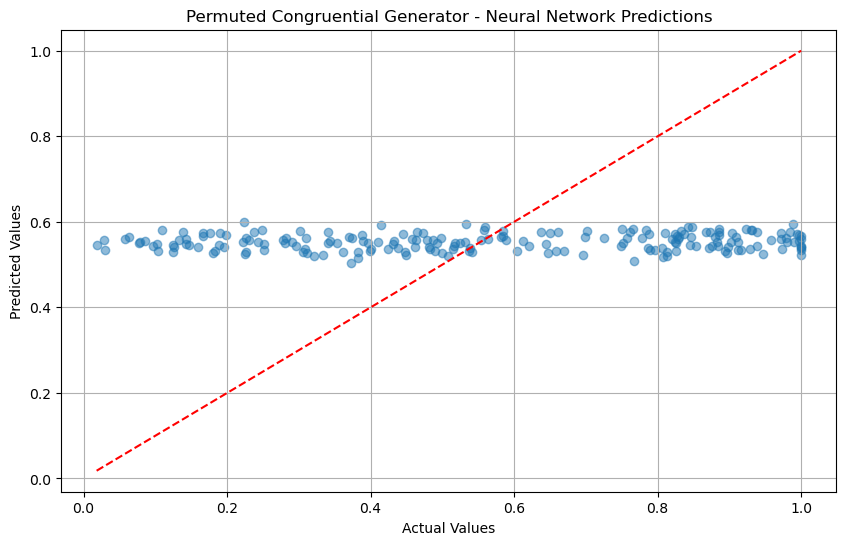

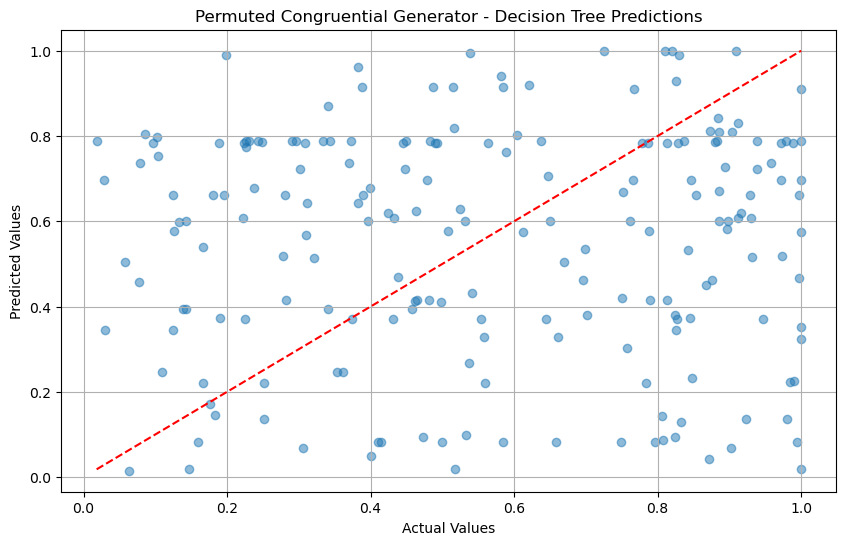


Experiment: SplitMix64 Generator
Data shape: X=(1000, 20), y=(1000,)

Training Neural Network...
Epoch [20/100], Loss: 0.116200
Epoch [40/100], Loss: 0.090689
Epoch [60/100], Loss: 0.087630
Epoch [80/100], Loss: 0.087267
Epoch [100/100], Loss: 0.087148
Neural Network - MSE: 0.083164, R²: 0.006321

Training Decision Tree...
Decision Tree - MSE: 0.169240, R²: -1.022140


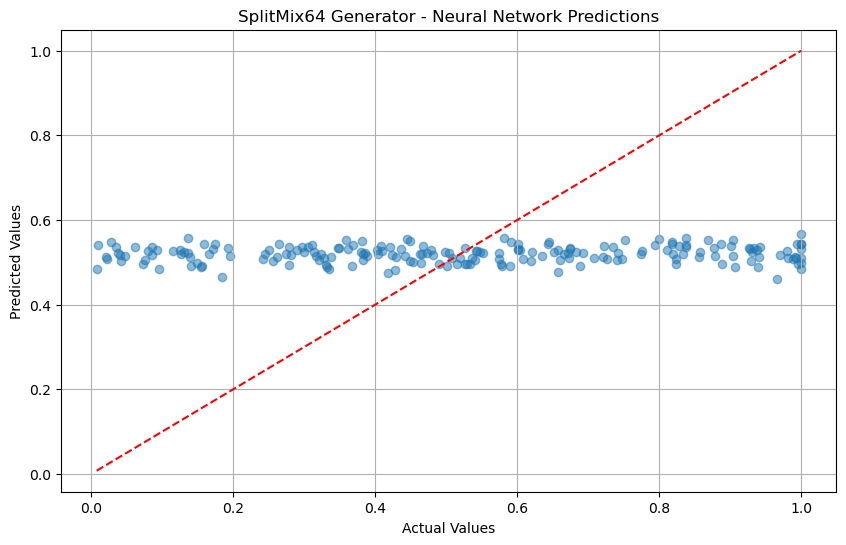

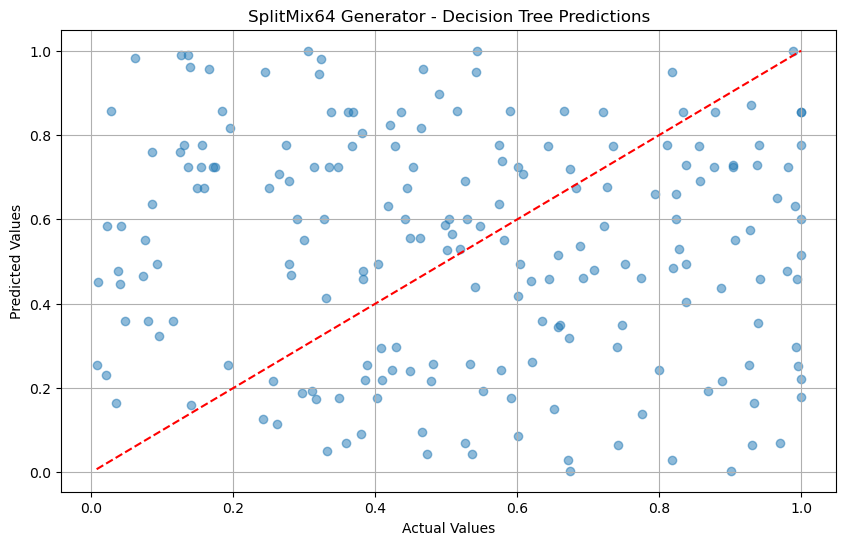


Experiment: AES-based PRNG
Data shape: X=(1000, 20), y=(1000,)

Training Neural Network...
Epoch [20/100], Loss: 0.173009
Epoch [40/100], Loss: 0.003065
Epoch [60/100], Loss: 0.001009
Epoch [80/100], Loss: 0.000097
Epoch [100/100], Loss: 0.000021
Neural Network - MSE: 0.000024, R²: 0.000000

Training Decision Tree...
Decision Tree - MSE: 0.000000, R²: 0.000000


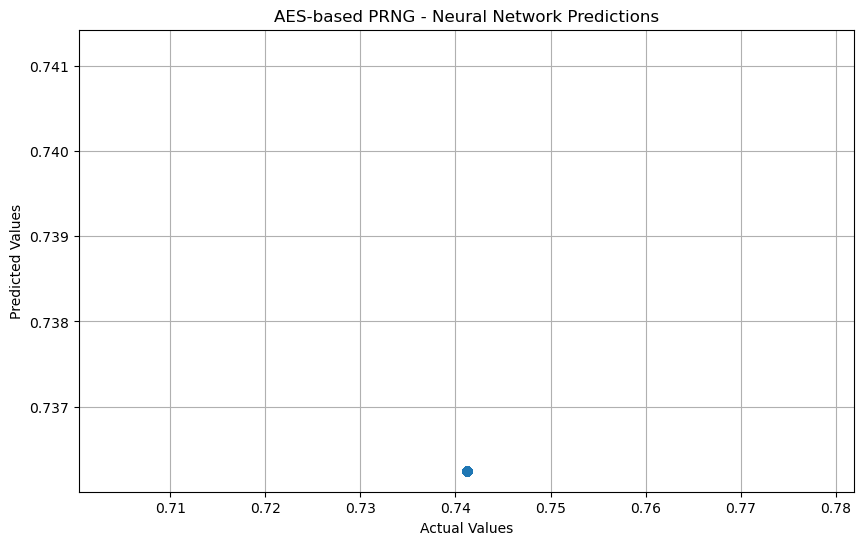

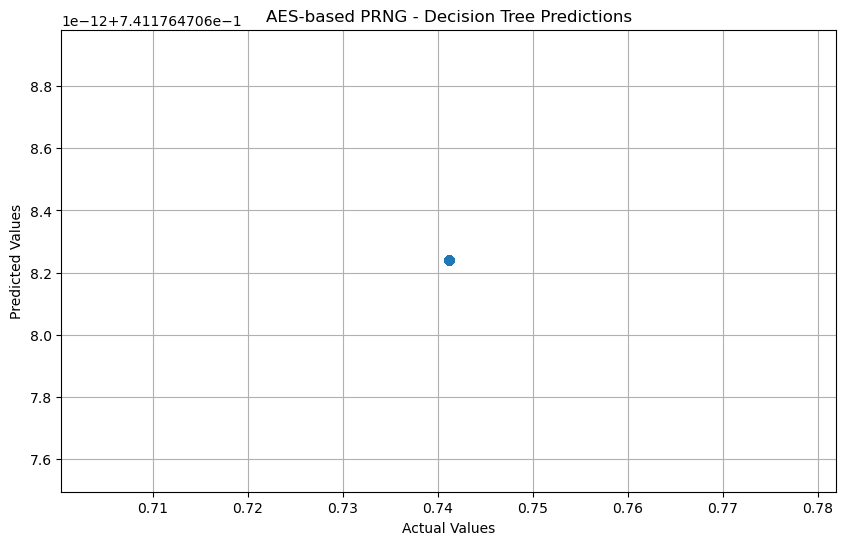


PRNG Predictability Comparison
PRNG            | Neural Network MSE   | Neural Network R²    | Decision Tree MSE    | Decision Tree R²    
--------------------------------------------------------------------------------
LCG             | 0.099640             | 0.002881             | 0.150138             | -0.502469           
XORShift        | 0.087801             | -0.013544            | 0.045875             | 0.470436            
PCG             | 0.085554             | 0.008231             | 0.156156             | -0.810218           
SplitMix64      | 0.083164             | 0.006321             | 0.169240             | -1.022140           
AES             | 0.000024             | 0.000000             | 0.000000             | 0.000000            


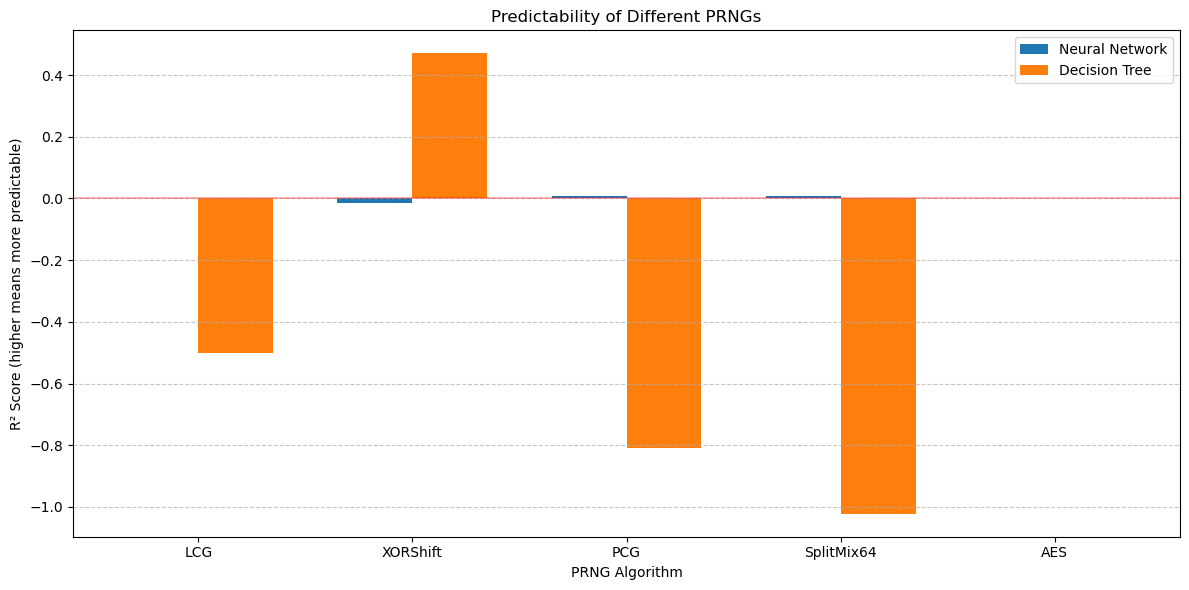

In [ ]:
# You may want to import these packages, though feel free to import anything else you need
def XORShift(seed, N_steps):
    """
    Generate a sequence using a XOR-Shift generator.
    
    Parameters:
    seed (int): Initial value of the sequence (must be non-zero).
    N_steps (int): Number of iterations to compute.
    
    Returns:
    List[int]: The list/array of XOR-Shift outputs, including the initial seed.
    """
    if seed == 0:
        seed = 1  # XORShift doesn't work with a seed of 0
    
    sequence = [seed]
    state = seed
    
    for _ in range(N_steps):
        # XORShift algorithm (32-bit version)
        state ^= (state << 13) & 0xFFFFFFFF
        state ^= (state >> 17) & 0xFFFFFFFF
        state ^= (state << 5) & 0xFFFFFFFF
        sequence.append(state)
    
    return sequence

def PCG(seed, N_steps, multiplier=6364136223846793005, increment=1442695040888963407):
    """
    Generate a sequence using a Permuted Congruential Generator (PCG).
    
    Parameters:
    seed (int): Initial value of the sequence.
    N_steps (int): Number of iterations to compute.
    multiplier (int): The multiplier in the LCG part.
    increment (int): The increment in the LCG part.
    
    Returns:
    List[int]: The list/array of PCG outputs.
    """
    sequence = []
    state = seed
    
    for _ in range(N_steps + 1):
        # Output function (permutation)
        output = ((state >> 18) ^ state) >> 27
        rot = state >> 59
        output = ((output >> rot) | (output << ((-rot) & 31))) & 0xFFFFFFFF
        sequence.append(output)
        
        # State update (LCG)
        state = (state * multiplier + increment) & 0xFFFFFFFFFFFFFFFF
    
    return sequence

def SplitMix64(seed, N_steps):
    """
    Generate a sequence using a SplitMix64 generator.
    
    Parameters:
    seed (int): Initial value of the sequence.
    N_steps (int): Number of iterations to compute.
    
    Returns:
    List[int]: The list/array of SplitMix64 outputs.
    """
    sequence = []
    state = seed
    
    for _ in range(N_steps + 1):
        # Update state
        state = (state + 0x9E3779B97F4A7C15) & 0xFFFFFFFFFFFFFFFF
        
        # Output function
        z = state
        z = ((z ^ (z >> 30)) * 0xBF58476D1CE4E5B9) & 0xFFFFFFFFFFFFFFFF
        z = ((z ^ (z >> 27)) * 0x94D049BB133111EB) & 0xFFFFFFFFFFFFFFFF
        output = z ^ (z >> 31)
        
        sequence.append(output & 0xFFFFFFFF)  # Return 32-bit values for consistency
    
    return sequence

def generate_sequences(prng_function, seed, seq_length, num_sequences, **kwargs):
    """
    Generate multiple sequences from a PRNG function.
    
    Parameters:
    prng_function: The PRNG function to use
    seed: Starting seed value
    seq_length: Length of each sequence
    num_sequences: Number of sequences to generate
    **kwargs: Additional arguments for the PRNG function
    
    Returns:
    X: Input sequences (all values except the last)
    y: Target values (last value of each sequence)
    """
    X = []
    y = []
    
    for i in range(num_sequences):
        current_seed = seed + i
        if prng_function.__name__ == 'Linear_Congruential_Generator':
            # Handle LCG specifically
            sequence = prng_function(current_seed, kwargs['multiplier'], kwargs['increment'], kwargs['modulus'], seq_length)
        else:
            # Handle other PRNGs
            sequence = prng_function(current_seed, seq_length, **kwargs)
        # Normalize the sequence to [0, 1] range for better training
        max_val = max(sequence)
        if max_val > 0:
            normalized_seq = [val / max_val for val in sequence]
        else:
            normalized_seq = sequence
        
        # Use all but the last value as input features
        X.append(normalized_seq[:-1])
        # Use the last value as the target
        y.append(normalized_seq[-1])
    
    return np.array(X), np.array(y)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Reshape input to (batch_size, seq_length, input_size)
        x = x.unsqueeze(-1)
        
        # Forward propagate through RNN
        out, _ = self.rnn(x)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

def train_nn_model(X_train, y_train, hidden_size=16, epochs=100, lr=0.001):
    """
    Train a simple RNN model to predict the next number in a sequence.
    
    Parameters:
    X_train: Training input sequences
    y_train: Training target values
    hidden_size: Size of the hidden layer
    epochs: Number of training epochs
    lr: Learning rate
    
    Returns:
    model: Trained PyTorch model
    losses: List of training losses
    """
    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    
    # Create model, loss function, and optimizer
    input_size = X_train.shape[1]
    model = SimpleRNN(input_size=input_size, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    losses = []
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return model, losses

from sklearn.tree import DecisionTreeRegressor

def train_decision_tree(X_train, y_train, max_depth=10):
    """
    Train a decision tree model to predict the next number in a sequence.
    
    Parameters:
    X_train: Training input sequences
    y_train: Training target values
    max_depth: Maximum depth of the tree
    
    Returns:
    model: Trained decision tree model
    """
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def evaluate_model(model_type, X_test, y_test, model):
    """
    Evaluate a trained model on test data.
    
    Parameters:
    model_type: 'nn' for neural network or 'dt' for decision tree
    X_test: Test input sequences
    y_test: Test target values
    model: Trained model
    
    Returns:
    mse: Mean squared error
    r2: R-squared score
    predictions: Model predictions
    """
    if model_type == 'nn':
        X_tensor = torch.FloatTensor(X_test)
        model.eval()
        with torch.no_grad():
            predictions = model(X_tensor).numpy().flatten()
    else:  # Decision tree
        predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return mse, r2, predictions

def plot_results(y_test, predictions, title):
    """
    Plot actual vs predicted values.
    
    Parameters:
    y_test: Actual values
    predictions: Predicted values
    title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()

def run_experiment(prng_name, prng_function, seed=42, seq_length=20, num_sequences=1000, **kwargs):
    """
    Run a complete experiment for a PRNG.
    
    Parameters:
    prng_name: Name of the PRNG for display
    prng_function: The PRNG function
    seed: Starting seed
    seq_length: Length of each sequence
    num_sequences: Number of sequences to generate
    **kwargs: Additional arguments for the PRNG function
    """
    print(f"\n{'='*50}")
    print(f"Experiment: {prng_name}")
    print(f"{'='*50}")
    
    # Generate data
    X, y = generate_sequences(prng_function, seed, seq_length, num_sequences, **kwargs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Data shape: X={X.shape}, y={y.shape}")
    
    # Train neural network model
    print("\nTraining Neural Network...")
    nn_model, losses = train_nn_model(X_train, y_train, hidden_size=32, epochs=100)
    
    # Evaluate neural network
    nn_mse, nn_r2, nn_preds = evaluate_model('nn', X_test, y_test, nn_model)
    print(f"Neural Network - MSE: {nn_mse:.6f}, R²: {nn_r2:.6f}")
    
    # Train decision tree model
    print("\nTraining Decision Tree...")
    dt_model = train_decision_tree(X_train, y_train, max_depth=10)
    
    # Evaluate decision tree
    dt_mse, dt_r2, dt_preds = evaluate_model('dt', X_test, y_test, dt_model)
    print(f"Decision Tree - MSE: {dt_mse:.6f}, R²: {dt_r2:.6f}")
    
    # Plot results
    plot_results(y_test, nn_preds, f'{prng_name} - Neural Network Predictions')
    plot_results(y_test, dt_preds, f'{prng_name} - Decision Tree Predictions')
    
    return {
        'nn_mse': nn_mse,
        'nn_r2': nn_r2,
        'dt_mse': dt_mse,
        'dt_r2': dt_r2
    }

# Parameters for LCG
lcg_params = {
    'multiplier': 1664525,
    'increment': 1013904223,
    'modulus': 2**32
}

# Run experiments
results = {}

# LCG experiment
results['LCG'] = run_experiment(
    'Linear Congruential Generator',
    Linear_Congruential_Generator,
    seed=12345,
    seq_length=20,
    num_sequences=1000,
    **lcg_params
)

# XORShift experiment
results['XORShift'] = run_experiment(
    'XOR-Shift Generator',
    XORShift,
    seed=12345,
    seq_length=20,
    num_sequences=1000
)

# PCG experiment
results['PCG'] = run_experiment(
    'Permuted Congruential Generator',
    PCG,
    seed=12345,
    seq_length=20,
    num_sequences=1000
)

# SplitMix64 experiment
results['SplitMix64'] = run_experiment(
    'SplitMix64 Generator',
    SplitMix64,
    seed=12345,
    seq_length=20,
    num_sequences=1000
)

# AES experiment (using a fixed seed for simplicity)
seed_bytes = b'0123456789abcdef'  # 16-byte seed for AES-128
aes_sequences = []
aes_targets = []

for i in range(1000):
    # Generate a sequence with AES
    random_bytes = AES_PRNG(seed_bytes, 21)  # 21 bytes (20 for sequence, 1 for target)
    normalized_seq = [b/255 for b in random_bytes]  # Normalize to [0,1]
    
    aes_sequences.append(normalized_seq[:-1])
    aes_targets.append(normalized_seq[-1])

X_aes = np.array(aes_sequences)
y_aes = np.array(aes_targets)

X_train, X_test, y_train, y_test = train_test_split(X_aes, y_aes, test_size=0.2, random_state=42)

print("\n" + "="*50)
print("Experiment: AES-based PRNG")
print("="*50)
print(f"Data shape: X={X_aes.shape}, y={y_aes.shape}")

# Train neural network for AES
print("\nTraining Neural Network...")
nn_model_aes, losses_aes = train_nn_model(X_train, y_train, hidden_size=32, epochs=100)

# Evaluate neural network
nn_mse_aes, nn_r2_aes, nn_preds_aes = evaluate_model('nn', X_test, y_test, nn_model_aes)
print(f"Neural Network - MSE: {nn_mse_aes:.6f}, R²: {nn_r2_aes:.6f}")

# Train decision tree for AES
print("\nTraining Decision Tree...")
dt_model_aes = train_decision_tree(X_train, y_train, max_depth=10)

# Evaluate decision tree
dt_mse_aes, dt_r2_aes, dt_preds_aes = evaluate_model('dt', X_test, y_test, dt_model_aes)
print(f"Decision Tree - MSE: {dt_mse_aes:.6f}, R²: {dt_r2_aes:.6f}")

# Plot results
plot_results(y_test, nn_preds_aes, 'AES-based PRNG - Neural Network Predictions')
plot_results(y_test, dt_preds_aes, 'AES-based PRNG - Decision Tree Predictions')

results['AES'] = {
    'nn_mse': nn_mse_aes,
    'nn_r2': nn_r2_aes,
    'dt_mse': dt_mse_aes,
    'dt_r2': dt_r2_aes
}

# Create a summary table
print("\n" + "="*80)
print("PRNG Predictability Comparison")
print("="*80)
print(f"{'PRNG':<15} | {'Neural Network MSE':<20} | {'Neural Network R²':<20} | {'Decision Tree MSE':<20} | {'Decision Tree R²':<20}")
print("-"*80)

for prng, metrics in results.items():
    print(f"{prng:<15} | {metrics['nn_mse']:<20.6f} | {metrics['nn_r2']:<20.6f} | {metrics['dt_mse']:<20.6f} | {metrics['dt_r2']:<20.6f}")

# Plot comparison of R² scores
plt.figure(figsize=(12, 6))
prng_names = list(results.keys())
nn_r2_scores = [results[prng]['nn_r2'] for prng in prng_names]
dt_r2_scores = [results[prng]['dt_r2'] for prng in prng_names]

x = np.arange(len(prng_names))
width = 0.35

plt.bar(x - width/2, nn_r2_scores, width, label='Neural Network')
plt.bar(x + width/2, dt_r2_scores, width, label='Decision Tree')

plt.xlabel('PRNG Algorithm')
plt.ylabel('R² Score (higher means more predictable)')
plt.title('Predictability of Different PRNGs')
plt.xticks(x, prng_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at R²=0 (no predictability)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()
